In [1]:
import os 
import json
import itertools
import operator
import pandas as pd
import numpy as np
import psutil
import multiprocessing
import shutil
import matplotlib.pyplot as plt
from time import time
from itertools import product
from functools import reduce
from pprint import pprint
from tqdm.notebook import tqdm 

import grid2op
from grid2op.PlotGrid import PlotMatplot
from lightsim2grid import LightSimBackend
from grid2op.Chronics import Multifolder, GridStateFromFile
from grid2op.Parameters import Parameters
from grid2op.Rules import AlwaysLegal
from grid2op.Agent import DoNothingAgent, OneChangeThenNothing
from grid2op.Runner import Runner
from grid2op.Episode import EpisodeData
from grid2op.Reward import L2RPNReward
from grid2op.Reward import L2RPNSandBoxScore

In [2]:
config = {
    'env_path': '/Users/antoinemarot/dev/Grid2Op/grid2op/data/rte_case14_realistic/',
    #'env_path': '/Users/camiloromero/data_grid2op/rte_case14_realistic/',
    'num_cores': psutil.cpu_count(logical=False),
    'min_path': False,
}

In [3]:
#to reinstall grid2op
#!echo password |sudo -S pip uninstall -y grid2op
#!echo password |sudo -S pip install grid2op

In [4]:
grid2op.__version__

'1.2.2'

In [5]:
grid_path = os.path.abspath(config['env_path'])

chronics_path = os.path.join(grid_path, 'chronics')

In [7]:
scenarios = next(os.walk(chronics_path))[1]
scenarios

['000', '001']

In [ ]:
maxIter=20 #if we don't want to run the full scenario, because it can be quite long depending on the size of action space explored 



## Load ENV and plot grid

In [9]:
try:
    from lightsim2grid.LightSimBackend import LightSimBackend
    backend = LightSimBackend()
except:
    from grid2op.Backend import PandaPowerBackend
    backend = PandaPowerBackend()

In [10]:
#scoring_function = L2RPNReward
#env = grid2op.make(reward_class=L2RPNReward, test=True)

param = Parameters()
param.init_from_dict({'NO_OVERFLOW_DISCONNECTION': True})
param.init_from_dict({'MAX_LINE_STATUS_CHANGED': 999})
param.init_from_dict({'MAX_SUB_CHANGED': 2999})

env = grid2op.make(grid_path,
                   reward_class=L2RPNReward,      # L2RPN 2019 (14 nodes)
#                    reward_class=L2RPNSandBoxScore,  # L2RPN 2020
                   backend=backend,
                   data_feeding_kwargs={"gridvalueClass": GridStateFromFile},
                   param=param,
                   gamerules_class=AlwaysLegal,
                   test=True,
                  )

In [11]:
# env.rewardClass

In [12]:
info_lines = {i:(l[0], l[1]) for i, l in enumerate(zip(env.line_or_to_subid, env.line_ex_to_subid))}

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



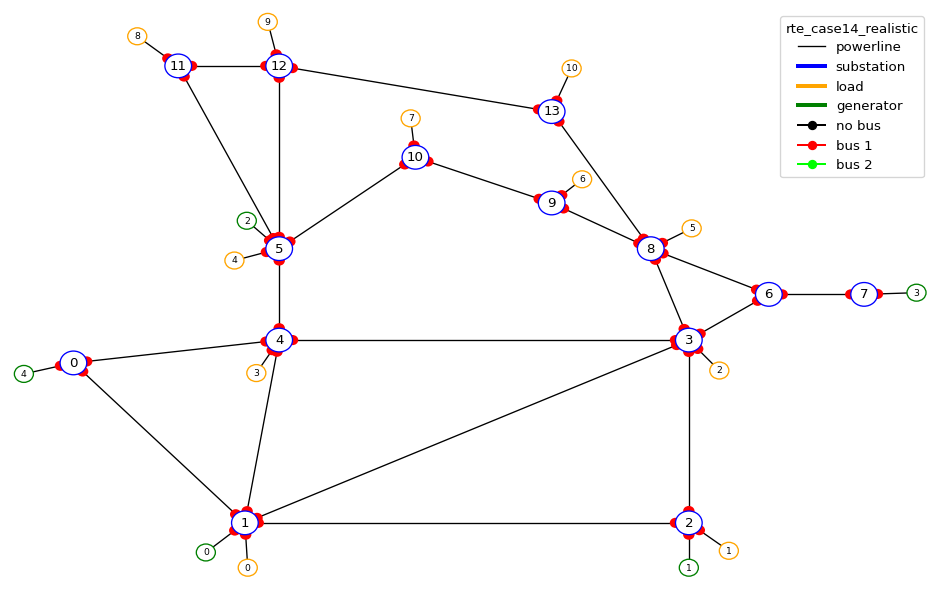

In [13]:
plot_helper = PlotMatplot(env.observation_space, 
                          sub_radius=14, 
                          load_radius=10, 
                          gen_radius=10,
                          width=950,
                          height=600,
                        )
plot_helper._line_bus_radius = 6
plot_helper._line_arrow_width = 10
plot_helper._line_arrow_len = 17


fig = plot_helper.plot_layout()
fig.show()

## Unitary actions
Load unitary actions dictionary and create configurations up to a certain depth

In [14]:
# with open('wcci_test_unitary_actions/actions_dict/agg_unitary_actions.json') as f: # L2RPN 2020
with open('lrpn_2019_unitary_actions/actions_dict/unitary_actions_l2rpn_2019.json') as f: # L2RPN 2019
    configurations = json.load(f)

In [15]:
pprint(configurations)

{'sub_1': {'a': {'lines_id_bus': [[0, 2], [4, 2]], 'loads_id_bus': [[0, 2]]},
           'b': {'lines_id_bus': [[0, 2], [4, 2], [2, 2]]},
           'c': {'lines_id_bus': [[0, 2], [3, 2], [4, 2]]},
           'd': {}},
 'sub_3': {'a': {'lines_id_bus': [[6, 2], [16, 2]]},
           'b': {'lines_id_bus': [[6, 2], [15, 2]]},
           'c': {'lines_id_bus': [[16, 2], [5, 2]]},
           'd': {'lines_id_bus': [[16, 2], [5, 2], [6, 2]]},
           'e': {}},
 'sub_4': {'a': {'lines_id_bus': [[4, 2]], 'loads_id_bus': [[3, 2]]},
           'b': {'lines_id_bus': [[4, 2], [6, 2]]},
           'c': {'lines_id_bus': [[1, 2], [17, 2]]},
           'd': {}},
 'sub_5': {'a': {'lines_id_bus': [[17, 2], [9, 2], [7, 2]]}, 'b': {}},
 'sub_8': {'a': {'lines_id_bus': [[19, 2], [10, 2], [11, 2]]},
           'b': {'lines_id_bus': [[16, 2], [11, 2]]},
           'c': {}}}


In [16]:
# Name of each target configuration
names_dic = {}
for key in configurations:
#     names = [str(key) + '_' + str(i+1) for i in range(len(configurations[key]))]
    names = [f'{key}_{c}' for c in configurations[key]]
    names_dic[key] = names

In [17]:
pprint(names_dic)

{'sub_1': ['sub_1_a', 'sub_1_b', 'sub_1_c', 'sub_1_d'],
 'sub_3': ['sub_3_a', 'sub_3_b', 'sub_3_c', 'sub_3_d', 'sub_3_e'],
 'sub_4': ['sub_4_a', 'sub_4_b', 'sub_4_c', 'sub_4_d'],
 'sub_5': ['sub_5_a', 'sub_5_b'],
 'sub_8': ['sub_8_a', 'sub_8_b', 'sub_8_c']}


In [ ]:
#TO DO: we should have combinations up to a certain "depth"
#for instance for depth=2, we would have [('sub_4_a'), ('sub_3_a'), ('sub_1_a'),... ('sub_1_b','sub_5_a'),('sub_8_b', 'sub_5_b')]
#no need to consider Do Nothing actions at each substation of interest in that propect

In [18]:
all_combs = list(itertools.product(*names_dic.values()))
all_combs[:10]

## Flatten combinations
#deepth = 2
#all_combs = reduce(operator.concat, [list(itertools.combinations(selected_actions.keys(), i)) 
#                                for i in range(1, deepth + 1)])


[('sub_4_a', 'sub_3_a', 'sub_1_a', 'sub_8_a', 'sub_5_a'),
 ('sub_4_a', 'sub_3_a', 'sub_1_a', 'sub_8_a', 'sub_5_b'),
 ('sub_4_a', 'sub_3_a', 'sub_1_a', 'sub_8_b', 'sub_5_a'),
 ('sub_4_a', 'sub_3_a', 'sub_1_a', 'sub_8_b', 'sub_5_b'),
 ('sub_4_a', 'sub_3_a', 'sub_1_a', 'sub_8_c', 'sub_5_a'),
 ('sub_4_a', 'sub_3_a', 'sub_1_a', 'sub_8_c', 'sub_5_b'),
 ('sub_4_a', 'sub_3_a', 'sub_1_b', 'sub_8_a', 'sub_5_a'),
 ('sub_4_a', 'sub_3_a', 'sub_1_b', 'sub_8_a', 'sub_5_b'),
 ('sub_4_a', 'sub_3_a', 'sub_1_b', 'sub_8_b', 'sub_5_a'),
 ('sub_4_a', 'sub_3_a', 'sub_1_b', 'sub_8_b', 'sub_5_b')]

https://www.quora.com/How-do-I-merge-multiple-dictionaries-values-having-the-same-key-in-Python

Derive the action to apply given a desired configuration

In [19]:
def get_state(*name_state, configurations=configurations):
    
    long_sub_action = {}
    long_line_action = {}
    
    for name in name_state[0]:
        prefix, num, id_ = name.split('_')
        # Form temportal key to call configuration dict
        tmp_key = f'{prefix}_{num}'
        
        if prefix == 'sub':
            # Get unitary sub action
            unitary_sub = configurations[tmp_key][id_]
            long_sub_action[int(num)] = unitary_sub
            
        if prefix == 'line':
            # Get unitary line action
            unitary_line = configurations[tmp_key][id_]
            long_line_action[int(num)] = unitary_line
            
    return long_sub_action, long_line_action

In [20]:
states = {i: {'sub': get_state(comb)[0],
              'line': get_state(comb)[1],
              } for i, comb in enumerate(all_combs)}

In [21]:
# Example 
states[0]

{'sub': {4: {'lines_id_bus': [[4, 2]], 'loads_id_bus': [[3, 2]]},
  3: {'lines_id_bus': [[6, 2], [16, 2]]},
  1: {'lines_id_bus': [[0, 2], [4, 2]], 'loads_id_bus': [[0, 2]]},
  8: {'lines_id_bus': [[19, 2], [10, 2], [11, 2]]},
  5: {'lines_id_bus': [[17, 2], [9, 2], [7, 2]]}},
 'line': {}}

## Get proper grid2op state

In [22]:
from sub_elems import get_valid_grid2op_action

no_ambiguous_states = {}
for state_name, state in states.items():
    sub, line = state['sub'], state['line']
    try:
        action_obj, action_dict = get_valid_grid2op_action(env, 
                                                           sub, 
                                                           line, 
                                                           verbose=False) 
        no_ambiguous_states[state_name] = action_dict
    except:
        continue

In [23]:
no_ambiguous_states[0]

{'set_bus': array([0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0,
        0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'set_line_status': []}

## Validate states after run PF
We test for each combination if the simulation has a chance to converge on the first time-step. Otherwise it is not a good one.

In [24]:
valid_states = {}
observation, reward, done, info = env.step(env.action_space({}))

with tqdm(total=len(no_ambiguous_states)) as pbar:
    for k, s in no_ambiguous_states.items():
#         obs, reward, done, info = observation.simulate(env.action_space(s), time_step=0)#env.step(env.action_space(s))
        obs, reward, done, info = observation.simulate(env.action_space(s), time_step=0)
        env.reset()
        if (not done) and (len(info["exception"]) == 0):
            valid_states[k] = s
        pbar.update(1)
        
print('There are {} valid over {} states\n'.format(len(valid_states), len(no_ambiguous_states)))
print(valid_states.keys())


There are 464 valid over 480 states

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

## Start Runner 

In [25]:
# Configure runner
nb_episode = len(next(os.walk(chronics_path))[1])
nb_process = config['num_cores']

In [26]:
agent_rel_path = os.path.abspath('agent_rel')

if os.path.exists(agent_rel_path):
    # If dir exists, delete it and create a new one
    shutil.rmtree(agent_rel_path)
    os.makedirs(agent_rel_path)
else: 
    os.makedirs(agent_rel_path)

In [ ]:
with tqdm(total=len(valid_states)) as pbar:
    for k, v in valid_states.items():
#         env.reset()
        agent_class = OneChangeThenNothing.gen_next(v)
        runner = Runner(**env.get_params_for_runner(), agentClass=agent_class)
        res_2 = runner.run(nb_episode=nb_episode, 
                           nb_process=nb_process, 
                           max_iter=maxIter,
                           path_save=os.path.join(agent_rel_path, str(k)))
        pbar.update(1)
del runner

## Create reward matrix
We now extract from the logs our reward
TO DO: we could have several "rewards" computed with grid2op to have more info when we will build the transition graph later

In [28]:
states = next(os.walk(agent_rel_path))[1]

In [29]:
scenarios = next(os.walk(chronics_path))[1]
scenarios

['000']

In [30]:
def create_reward_dataframe(state, 
                            scenarios=scenarios, 
                            agent_rel_path=agent_rel_path):
    
    dff = []
    for scenario in scenarios:
        
        # Read agent results
        episode_data = EpisodeData.from_disk(os.path.join(agent_rel_path, state), scenario)
    
        # Verbose
        print('State: {} - Scenario: {:<22} Max Time steps {}'.format(state, 
                                                                      scenario, 
                                                                      episode_data.meta['nb_timestep_played']))
        
        # Get rewards
        rewards = episode_data.rewards
        df = pd.DataFrame(rewards, columns=[f'rewards_{state}'])
        df['scenario'] = scenario
        
        dff.append(df)
        
#         # Get datetime
#         df['month'] = np.array([obs.month for obs in episode_data.observations])[1:]
#         df['day'] = np.array([obs.day for obs in episode_data.observations])[1:]
#         df['hour'] = np.array([obs.hour_of_day for obs in episode_data.observations])[1:]
#         df['minute'] = np.array([obs.minute_of_hour for obs in episode_data.observations])[1:]
#         # Convert to datatime
#         df['year'] = 2012
#         df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
#         del df['month'], df['day'], df['hour'], df['minute'], df['year']
        
# #         df.set_index('time', inplace=True)
#         del df['time']
        
#         if df.shape[0] < 864:
#             tmp_df = pd.DataFrame({'scenario': [0] * (864 - df.shape[0])})
#             tmp_df['scenario'] = scenario
#             df = pd.concat([df, tmp_df], axis=0)
            
#         dff = pd.concat([dff, df], axis=0)
        
    return pd.concat([df for df in dff], axis=0)

In [31]:
# # Test func
# create_reward_dataframe(states[2])

In [32]:
file_name = 'rewards.csv'

t0 = time()
pool = multiprocessing.Pool(nb_process)
rewards_df = pd.concat(pool.map(create_reward_dataframe, states), axis=1)
pool.close()
t1 = time()
print('Time taken = {} min'.format((t1-t0)/60))

# Personalize dataframe
scenario_col = rewards_df.scenario.iloc[:, 0]
rewards_df.drop('scenario', axis=1, inplace=True)
rewards_df.insert(0, 'scenario', scenario_col.values)

if config['min_path']:
    rewards_df.fillna(99999, inplace=True)   # When you want to MINIMIZE THE PATH
else:
    rewards_df.fillna(0, inplace=True)   # When you want to MAXIMIZE THE PATH


# Save it to csv
rewards_df.to_csv(file_name)

State: 398 - Scenario: 000                    Max Time steps 8064
State: 135 - Scenario: 000                    Max Time steps 8064
State: 193 - Scenario: 000                    Max Time steps 8064
State: 289 - Scenario: 000                    Max Time steps 8064
State: 35 - Scenario: 000                    Max Time steps 8064
State: 307 - Scenario: 000                    Max Time steps 8064
State: 242 - Scenario: 000                    Max Time steps 8064
State: 355 - Scenario: 000                    Max Time steps 8064
State: 61 - Scenario: 000                    Max Time steps 2
State: 195 - Scenario: 000                    Max Time steps 8064
State: 414 - Scenario: 000                    Max Time steps 8064
State: 167 - Scenario: 000                    Max Time steps 8064
State: 95 - Scenario: 000                    Max Time steps 8064
State: 353 - Scenario: 000                    Max Time steps 8064
State: 477 - Scenario: 000                    Max Time steps 8064
State: 397 - Sce

In [33]:
rewards_df.head()

,scenario,rewards_135,rewards_307,rewards_61,rewards_95,rewards_338,rewards_300,rewards_132,rewards_59,rewards_92,...,rewards_14,rewards_182,rewards_344,rewards_176,rewards_22,rewards_149,rewards_171,rewards_343,rewards_185,rewards_388
0,000,15.544678,15.334645,0.0,15.923059,13.295711,0.0,12.553727,16.067440,12.657386,...,13.175545,10.083261,13.141179,13.198183,13.868277,15.273135,15.583221,15.420815,13.996116,13.320590
1,000,15.529463,15.279513,0.0,15.876092,13.206120,0.0,12.506397,16.032618,12.614249,...,13.159655,10.355207,13.050347,13.128224,13.808628,15.319910,15.530590,15.360577,14.085559,13.312389
2,000,15.558784,15.340264,0.0,15.933270,13.308941,0.0,12.613354,16.060616,12.794056,...,13.197915,10.271022,13.170179,13.246445,13.875764,15.294630,15.575570,15.432715,14.048141,13.339405
3,000,15.586547,15.371600,0.0,15.945747,13.323692,0.0,12.608727,16.094797,12.755759,...,13.236300,10.309238,13.175028,13.268039,13.905323,15.359059,15.599242,15.462725,14.074714,13.393047
4,000,15.628961,15.413688,0.0,15.986158,13.379869,0.0,12.638037,16.128023,12.821815,...,13.291741,10.312976,13.239091,13.328225,13.950562,15.424251,15.630280,15.502772,14.122160,13.453857


## Create configuration table
The configuration table will allow us to compute the allowed transition given the rules of limited actions at a given timestep

In [36]:
# Retrieve configuration table in:
scenario = scenarios[0]
id_obs = 1

# Initialize configuration table
states_table = pd.DataFrame(columns=env.name_sub.tolist() + env.name_line.tolist())

for state in states:
    
    # Get one observation
    episode_data = EpisodeData.from_disk(os.path.join(agent_rel_path, state), scenario)
    obs = episode_data.observations[id_obs]
    
    # Sub states
    # Replace -1 state by 0
    sub_states = {}
    for n in env.name_sub:
        sub_state = obs.state_of(substation_id=int(n.split('_')[-1]))['topo_vect'] - 1
        sub_state = np.where(sub_state == -2, 0, sub_state)
        sub_states[n] = sub_state.tolist()
        
#     sub_states = {n: (obs.state_of(substation_id=int(n.split('_')[-1]))['topo_vect'] - 1).tolist() 
#                   for n in env.name_sub}
    
    # Line states
    line_states = {n: 1 - l_status.astype(int) 
                   for n, l_status in zip(env.name_line, vars(obs)['line_status'])}
    
    # Fill configuration table 
    states_table.loc[state] = {**sub_states, **line_states}

In [37]:
states_table.head(6)

,sub_0,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,...,8_9_10,8_13_11,9_10_12,11_12_13,12_13_14,3_6_15,3_8_16,4_5_17,6_7_18,6_8_19
135,"[0, 0, 0]","[1, 0, 1, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 1, 0, 1, 0]","[0, 1, 1, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[0, 1, 1, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
307,"[0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0, 1, 0]","[1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[1, 1, 0, 1, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
61,"[0, 0, 0]","[1, 0, 1, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0, 1, 0]","[0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[1, 1, 0, 1, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
95,"[0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 1, 0, 1, 0]","[0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
338,"[0, 0, 0]","[1, 0, 0, 1, 0, 1]","[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[1, 0, 0, 1, 0]","[1, 0, 1, 1, 0, 0]","[0, 0, 0]","[0, 0]","[0, 1, 1, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
300,"[0, 0, 0]","[1, 0, 1, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0, 1, 0]","[1, 0, 0, 1, 0]","[1, 0, 1, 1, 0, 0]","[0, 0, 0]","[0, 0]","[1, 1, 0, 1, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0


In [38]:
states_table.to_csv('states_table.csv', index=True)

In [ ]:
states_table.index

In [ ]:
len(states)